In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



In [2]:
# Facial Emotion Recognition Model - Optimized for Snapdragon X Elite
# =======================================================================
# Configuration: MOBILENET with optimized hyperparameters
# Target: <1 hour training time with maximum accuracy

import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image, UnidentifiedImageError

# Import TensorFlow and configure for optimal performance
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"Python executable: {sys.executable}")

import seaborn as sns

# Import deep learning libraries
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Flatten, Dropout, Dense, Input, 
                                     GlobalAveragePooling2D, Conv2D, 
                                     BatchNormalization, Activation, MaxPooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0



TensorFlow version: 2.19.1
Python executable: c:\Users\marty\anaconda3\envs\tf311_env\python.exe


In [3]:
def is_on_kaggle () -> bool:
    """Check if we are running on Kaggle."""
    return os.path.exists('/kaggle/input')

In [4]:
# Detect environment
def get_data_path():
    """Detect if running on Kaggle or local machine."""
    if is_on_kaggle():
        # Running on Kaggle
        print("🌐 Running on Kaggle")
        import kagglehub
        image_path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")
        folder_path = os.path.join(image_path, "images")
    else:
        # Running locally
        print("💻 Running on local machine")
        folder_path = "data/images/"

    return folder_path
# get path to immages

folder_path = get_data_path()
print(f"Data folder path: {folder_path}")

💻 Running on local machine
Data folder path: data/images/


In [ ]:
# =======================================================================
# Configuration Parameters
# =======================================================================


cfg = {
    # Model Architecture
    "backbone": "custom_cnn",  # Options: "mobilenet", "efficientnet", "custom_cnn"

    # Image Parameters
    "picture_size": 48,
    "color_mode": "grayscale",  # Options: "grayscale", "rgb"

    # Training Parameters
    "batch_size": 64,
    "epochs": 30,
    "learning_rate": 0.001,
    "dropout_rate": 0.3,

    # CNN Architecture (for custom_cnn)
    "cnn_layers": [
        {"filters": 64, "kernel_size": (3, 3)},
        {"filters": 128, "kernel_size": (5, 5)},
        {"filters": 512, "kernel_size": (3, 3)},
        {"filters": 512, "kernel_size": (3, 3)}
    ],
    
    # Dense layers (for custom_cnn)
    "dense_units": [256, 512],

    # Data Augmentation
    "aug_level": "light",  # Options: "none", "light", "strong"

    # Advanced Training
    "precision": "float32",  # Options: "float32", "mixed"
    "fine_tune": False,
    "fine_tune_epochs": 10,

    # Model Parameters
    "no_of_classes": 7,
}

print("Configuration loaded:")
for key, value in cfg.items():
    print(f"  {key}: {value}")

Configuration loaded:
  backbone: custom_cnn
  picture_size: 48
  color_mode: grayscale
  batch_size: 128
  epochs: 30
  learning_rate: 0.0001
  dropout_rate: 0.25
  cnn_layers: [{'filters': 64, 'kernel_size': (3, 3)}, {'filters': 128, 'kernel_size': (5, 5)}, {'filters': 512, 'kernel_size': (3, 3)}, {'filters': 512, 'kernel_size': (3, 3)}]
  dense_units: [256, 512]
  aug_level: light
  precision: float32
  fine_tune: False
  fine_tune_epochs: 10
  no_of_classes: 7


In [6]:
# optionally, map top-level training params from cfg
picture_size   = cfg.get("picture_size", 48)
batch_size     = cfg.get("batch_size", 128)
epochs         = cfg.get("epochs", 30)
no_of_classes  = cfg.get("no_of_classes", 7)
learning_rate  = cfg.get("learning_rate", 1e-4)


# Enable mixed precision for faster training on Snapdragon X Elite
from tensorflow.keras import mixed_precision

# Precision Switch
if cfg.get("precision", "float32") == "mixed":
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision training enabled - expect 2-3x speedup!")
else:
    mixed_precision.set_global_policy('float32')
    print("Using float32 precision")
    

Using float32 precision


In [7]:
# =======================================================================
# Image Validation and Cleaning
# =======================================================================

def is_image_valid(filepath):
    """Validate image integrity."""
    try:
        with Image.open(filepath) as img:
            img.verify()
        return True
    except (UnidentifiedImageError, OSError):
        return False

def delete_if_corrupt(filepath):
    """Delete corrupted images."""
    try:
        with Image.open(filepath) as img:
            img.verify()
        return False
    except (UnidentifiedImageError, OSError):
        print(f"Deleting corrupted image: {filepath}")
        os.remove(filepath)
        return True


# =======================================================================
# Advanced Image Preprocessing
# =======================================================================

def preprocess_image(image):
    """
    Apply histogram equalization for better feature extraction.
    Improves contrast and enhances facial features.
    """
    # Convert to uint8 if needed
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    if len(image.shape) == 2:  # Grayscale
        enhanced = clahe.apply(image)
    else:  # If RGB, convert to grayscale first
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        enhanced = clahe.apply(gray)
    
    # Normalize to [0, 1]
    return enhanced.astype(np.float32) / 255.0

class PreprocessingImageDataGenerator(ImageDataGenerator):
    """Custom generator with advanced preprocessing."""
    
    def __init__(self, *args, preprocessing_function=None, **kwargs):
        super().__init__(*args, preprocessing_function=preprocessing_function, **kwargs)
    
    def standardize(self, x):
        x = super().standardize(x)
        # Apply additional preprocessing
        return preprocess_image(x)

In [8]:
# =======================================================================
# Data Augmentation and Loading
# =======================================================================

aug_map = {
    "none": dict(rescale=1./255),
    "light": dict(rescale=1./255, rotation_range=10, width_shift_range=0.1,
                  height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True),
    "strong": dict(rescale=1./255, rotation_range=20, width_shift_range=0.15,
                   height_shift_range=0.15, shear_range=0.15, zoom_range=0.15,
                   brightness_range=[0.8,1.2], horizontal_flip=True)
}

# Training data generator with standard augmentation
datagen_train = ImageDataGenerator(**aug_map[cfg["aug_level"]])

datagen_validation = ImageDataGenerator(rescale=1./255)                                        

# Create training set
train_set = datagen_train.flow_from_directory(
    os.path.join(folder_path, "train"),
    target_size=(picture_size, picture_size),
    color_mode=cfg["color_mode"],
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

# Create validation set
validation_set = datagen_validation.flow_from_directory(
    os.path.join(folder_path, "validation"),
    target_size=(picture_size, picture_size),
    color_mode=cfg["color_mode"],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # stable evaluation
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


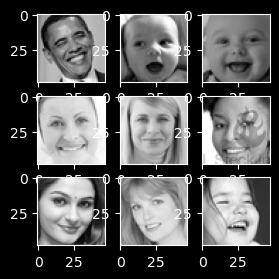

In [9]:
expression = 'happy'
plt.style.use('dark_background')
plt.figure(figsize=(3,3))
for i in range(1,10,1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+ os.listdir(folder_path+"train/"+expression)[i],target_size=(picture_size,picture_size))
    plt.imshow(img)
plt.show()      

In [10]:
print(f"Training samples: {train_set.n}")
print(f"Validation samples: {validation_set.n}")
print(f"Class indices: {train_set.class_indices}")


# =======================================================================
# Model Architecture - MobileNetV2 (Transfer Learning)
# =======================================================================
from tensorflow.keras import layers
# Build model (one path only)

def build_custom_cnn(cfg):
    """Build custom CNN model using configuration parameters."""
    
    # Extract config values
    picture_size = cfg.get("picture_size", 48)
    no_of_classes = cfg.get("no_of_classes", 7)
    learning_rate = cfg.get("learning_rate", 1e-4)
    dropout_rate = cfg.get("dropout_rate", 0.25)
    dense_units = cfg.get("dense_units", [256, 512])
    
    # Get CNN layer configuration
    cnn_layers = cfg.get("cnn_layers", [
        {"filters": 64, "kernel_size": (3, 3)},
        {"filters": 128, "kernel_size": (5, 5)},
        {"filters": 512, "kernel_size": (3, 3)},
        {"filters": 512, "kernel_size": (3, 3)}
    ])
    
    # Determine input shape based on color mode
    color_mode = cfg.get("color_mode", "grayscale")  # "grayscale" or "rgb"
    channels = 1 if color_mode == "grayscale" else 3
    input_shape = (picture_size, picture_size, channels)
    
    model = Sequential()
    
    # Build CNN layers dynamically
    for i, layer_cfg in enumerate(cnn_layers):
        filters = layer_cfg["filters"]
        kernel_size = layer_cfg["kernel_size"]
        
        if i == 0:
            model.add(Conv2D(filters, kernel_size, padding='same', input_shape=input_shape))
        else:
            model.add(Conv2D(filters, kernel_size, padding='same'))
        
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    
    # Build dense layers dynamically
    for units in dense_units:
        model.add(Dense(units))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(no_of_classes, activation='softmax'))
    
    # Compile model
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


# Build the model
model = build_custom_cnn(cfg)
model.summary()



# Cell 8: Compile Model
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Model compiled with learning rate: {learning_rate}")

Training samples: 28821
Validation samples: 7066
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


c:\Users\marty\anaconda3\envs\tf311_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

Model compiled with learning rate: 0.0001


In [11]:
# =======================================================================
# Training Callbacks
# =======================================================================

# Create callbacks for training
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks_list= [checkpoint, early_stopping, reduce_lr]
print("Callbacks configured")

Callbacks configured


In [12]:
# =======================================================================
# Model Training
# =======================================================================

print("Starting training...")
print(f"Target: {epochs} epochs with early stopping")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print("Mixed precision: ENABLED")

history = model.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=epochs,
    validation_data=validation_set,
    validation_steps=validation_set.n // validation_set.batch_size,
    callbacks=callbacks_list,
    verbose=1
)
print("✅ Model training complete!")


Starting training...
Target: 30 epochs with early stopping
Batch size: 128
Learning rate: 0.0001
Mixed precision: ENABLED


c:\Users\marty\anaconda3\envs\tf311_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1977 - loss: 2.1610
Epoch 1: val_accuracy improved from None to 0.17273, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 594s 3s/step - accuracy: 0.2156 - loss: 2.0581 - val_accuracy: 0.1727 - val_loss: 1.8789 - learning_rate: 1.0000e-04
Epoch 2/30
  1/225 ━━━━━━━━━━━━━━━━━━━━ 9:19 2s/step - accuracy: 0.2109 - loss: 1.9771

c:\Users\marty\anaconda3\envs\tf311_env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.17273
225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 187ms/step - accuracy: 0.2109 - loss: 1.9771 - val_accuracy: 0.1727 - val_loss: 1.8777 - learning_rate: 1.0000e-04
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2411 - loss: 1.9233
Epoch 3: val_accuracy improved from 0.17273 to 0.19006, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 586s 3s/step - accuracy: 0.2435 - loss: 1.9129 - val_accuracy: 0.1901 - val_loss: 1.8559 - learning_rate: 1.0000e-04
Epoch 4/30
  1/225 ━━━━━━━━━━━━━━━━━━━━ 8:44 2s/step - accuracy: 0.2344 - loss: 1.8438
Epoch 4: val_accuracy improved from 0.19006 to 0.19304, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 80s 349ms/step - accuracy: 0.2344 - loss: 1.8438 - val_accuracy: 0.1930 - val_loss: 1.8545 - learning_rate: 1.0000e-04
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2580 - loss: 1.8676
Epoch 5: val_accuracy improved from 0.19304 to 0.29986, saving model to


Skipping fine-tuning (only applicable for transfer learning models)


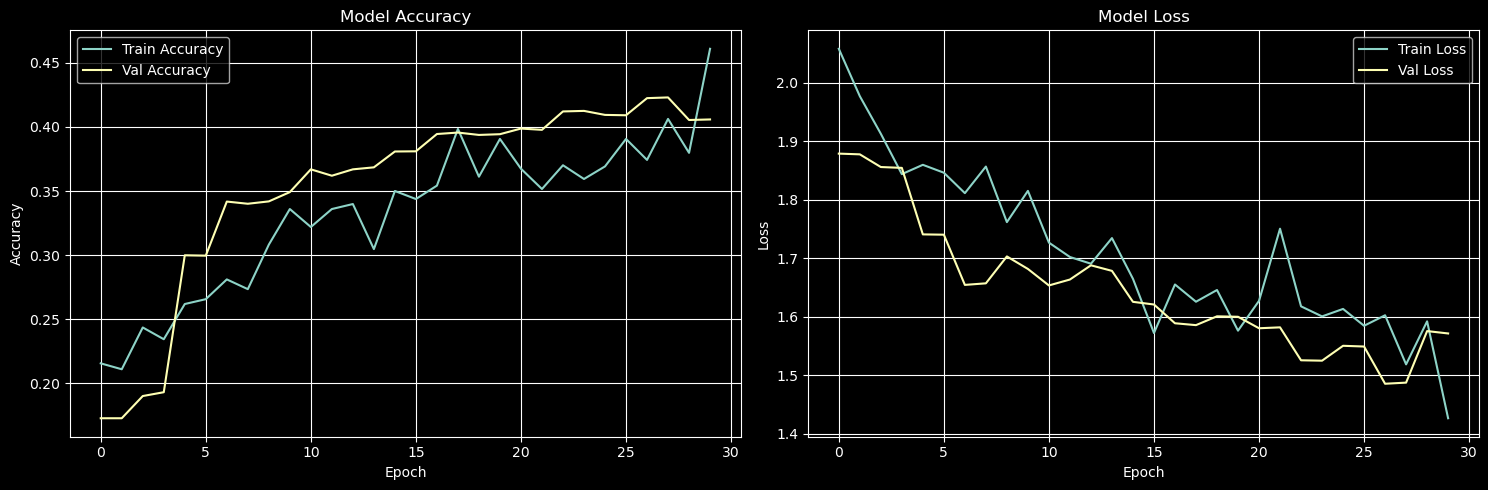


Final Evaluation:
Training Accuracy: 0.3859
Validation Accuracy: 0.4233
Training Loss: 1.6008
Validation Loss: 1.4848

Model saved as 'emotion_recognition_final.keras'


In [16]:
# ---- Phase 2: fine-tune (switch applied here) ----
# Unfreeze the base model for fine-tuning (only for transfer learning models)
if cfg.get("backbone") in ["mobilenet", "efficientnet"] and cfg.get("fine_tune", False):
    print("\nStarting fine-tuning phase...")
    
    # Get the base model from the built model
    base_model = model.layers[0]  # First layer is the base model
    
    # Unfreeze the last few layers
    base_model.trainable = True
    fine_tune_at = len(base_model.layers) - 20  # Unfreeze last 20 layers
    
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate/10),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Fine-tune for additional epochs
    fine_tune_epochs = cfg.get("fine_tune_epochs", 10)
    history_fine = model.fit(
        train_set,
        validation_data=validation_set,
        epochs=fine_tune_epochs,
        callbacks=callbacks_list,
        verbose=1
    )
    
    print("Fine-tuning completed!")
else:
    print("\nSkipping fine-tuning (only applicable for transfer learning models)")

# Cell 12: Evaluation and Visualization
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Final evaluation
print("\nFinal Evaluation:")
train_loss, train_acc = model.evaluate(train_set, verbose=0)
val_loss, val_acc = model.evaluate(validation_set, verbose=0)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

print("\nModel saved as 'emotion_recognition_final.keras'")

Generating predictions on validation set...


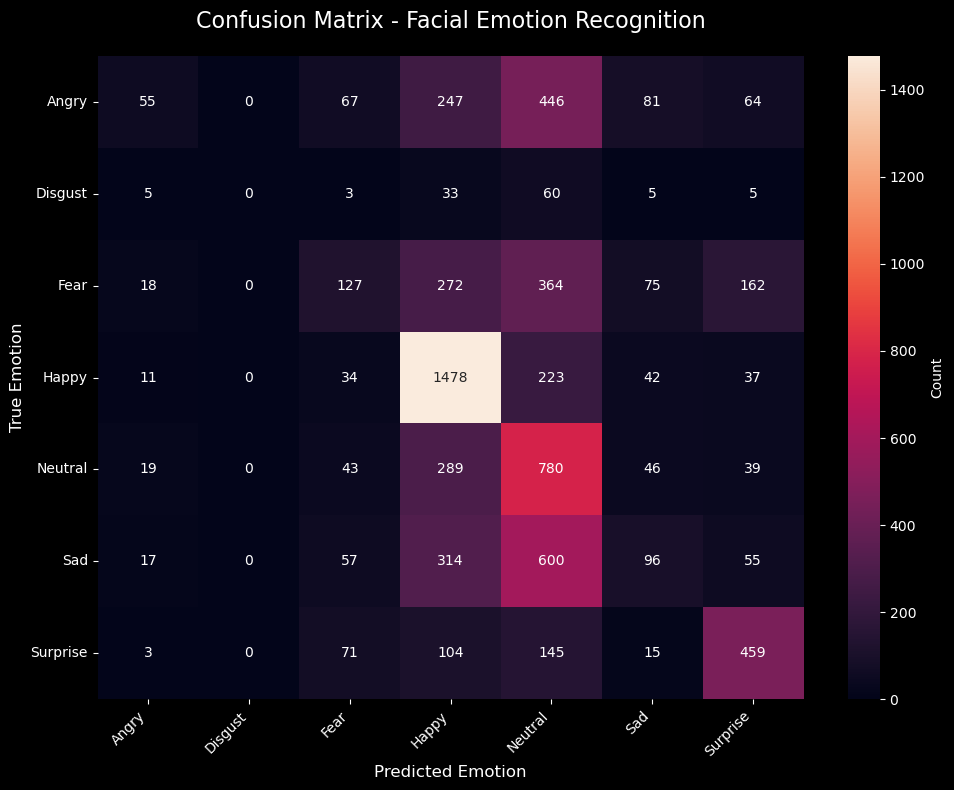


📈 DETAILED CLASSIFICATION METRICS
              precision    recall  f1-score   support

       Angry       0.43      0.06      0.10       960
     Disgust       0.00      0.00      0.00       111
        Fear       0.32      0.12      0.18      1018
       Happy       0.54      0.81      0.65      1825
     Neutral       0.30      0.64      0.41      1216
         Sad       0.27      0.08      0.13      1139
    Surprise       0.56      0.58      0.57       797

    accuracy                           0.42      7066
   macro avg       0.34      0.33      0.29      7066
weighted avg       0.40      0.42      0.36      7066



c:\Users\marty\anaconda3\envs\tf311_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\marty\anaconda3\envs\tf311_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\marty\anaconda3\envs\tf311_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

In [19]:
# =======================================================================
# Detailed Performance Analysis
# =======================================================================

from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model

class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Load best model
my_model = load_model('best_model.keras', compile=False)

# Generate predictions on validation set
print("Generating predictions on validation set...")
predictions = []
true_labels = []

for i in range(len(validation_set)):
    batch_images, batch_labels = validation_set[i]
    batch_predictions = my_model.predict(batch_images, verbose=0)
    predictions.extend(np.argmax(batch_predictions, axis=1))
    true_labels.extend(np.argmax(batch_labels, axis=1))
    if i >= validation_set.n // validation_set.batch_size:
        break

predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', 
            xticklabels=class_labels, 
            yticklabels=class_labels,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Facial Emotion Recognition', fontsize=16, pad=20)
plt.xlabel('Predicted Emotion', fontsize=12)
plt.ylabel('True Emotion', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Classification Report
print("\n" + "="*70)
print("📈 DETAILED CLASSIFICATION METRICS")
print("="*70)
print(classification_report(true_labels, predictions, target_names=class_labels))

In [25]:
# =======================================================================
# Save Model (Versioned) - Enhanced with models/ directory
# =======================================================================

from pathlib import Path
from datetime import datetime

# Save full model with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"emotion_recognition_{timestamp}.keras"

if is_on_kaggle():
    output_path = "/kaggle/working/"
else:
    output_path = "."

# Use Path for cleaner path joining
full_path = Path(output_path) / model_name
model.save(str(full_path))



    


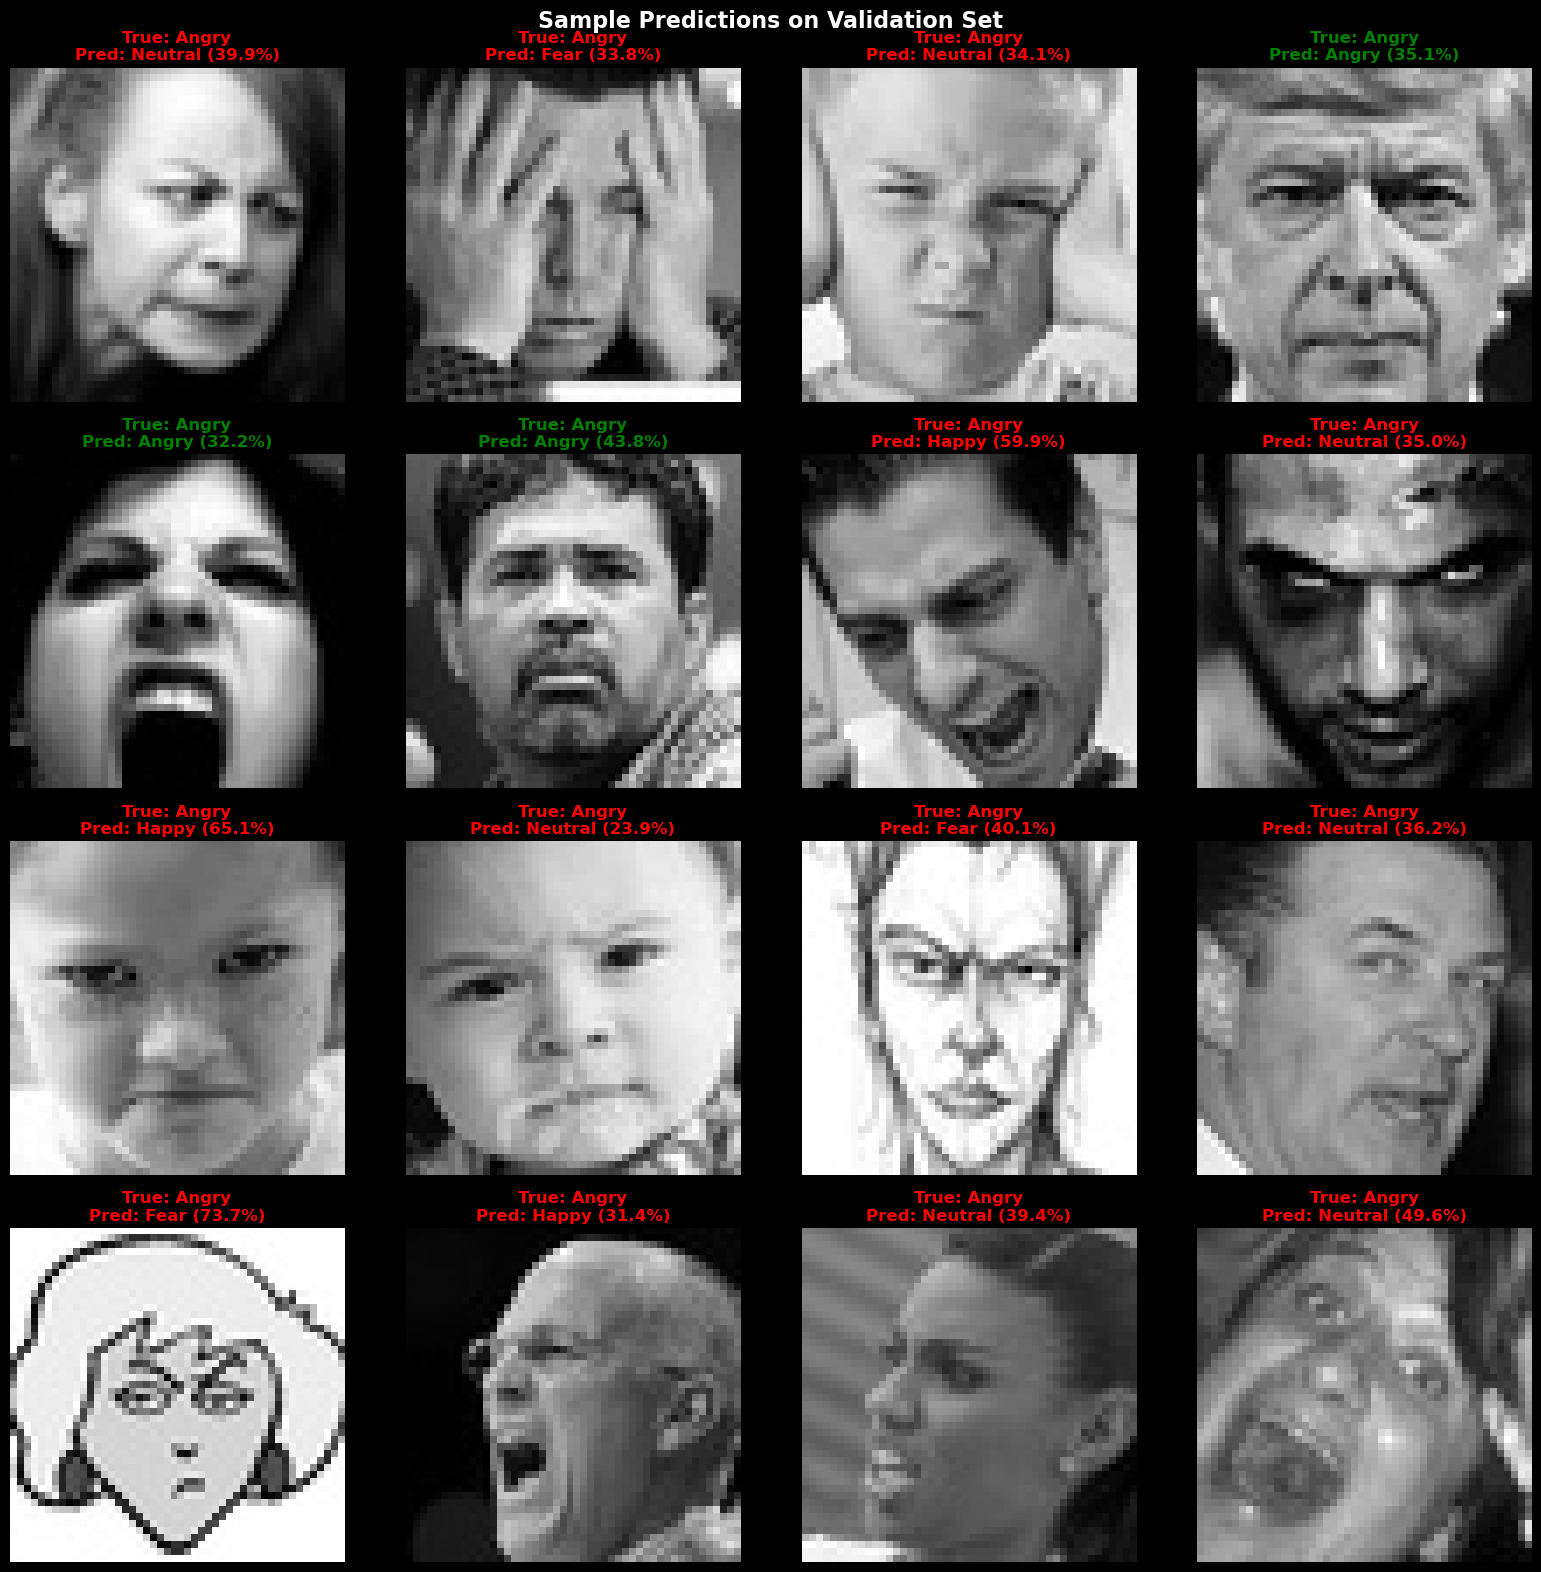

In [26]:
# =======================================================================
# Sample Predictions Visualization
# =======================================================================

# Get a batch of validation images
validation_set.reset()
sample_images, sample_labels = next(validation_set)

# Predict
sample_preds = my_model.predict(sample_images, verbose=0)
sample_pred_classes = np.argmax(sample_preds, axis=1)
sample_true_classes = np.argmax(sample_labels, axis=1)

# Visualize first 16 predictions
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.ravel()

for i in range(16):
    axes[i].imshow(sample_images[i].squeeze(), cmap='gray')
    
    true_label = class_labels[sample_true_classes[i]]
    pred_label = class_labels[sample_pred_classes[i]]
    confidence = sample_preds[i][sample_pred_classes[i]] * 100
    
    # Color: green if correct, red if wrong
    color = 'green' if sample_true_classes[i] == sample_pred_classes[i] else 'red'
    
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)', 
                     color=color, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Predictions on Validation Set', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step
Accuracy: 0.4233


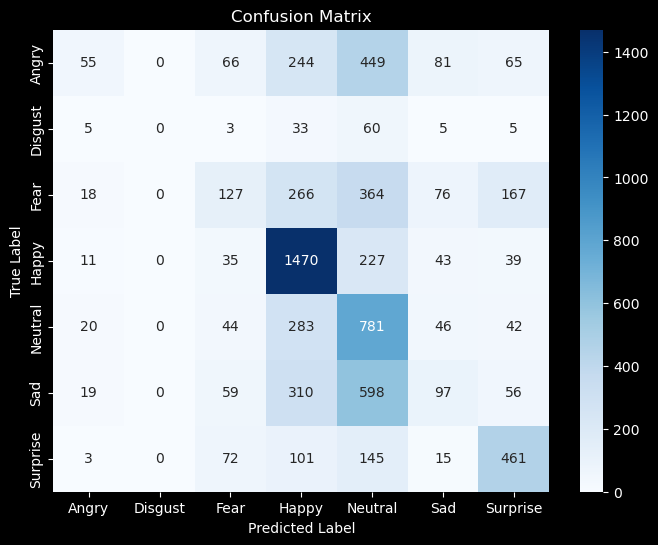


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       Angry       0.42      0.06      0.10       960
     Disgust       0.00      0.00      0.00       111
        Fear       0.31      0.12      0.18      1018
       Happy       0.54      0.81      0.65      1825
     Neutral       0.30      0.64      0.41      1216
         Sad       0.27      0.09      0.13      1139
    Surprise       0.55      0.58      0.56       797

    accuracy                           0.42      7066
   macro avg       0.34      0.33      0.29      7066
weighted avg       0.40      0.42      0.36      7066



In [28]:
# Get predictions on entire validation set
validation_set.reset()  # Reset iterator to start from beginning
predictions = model.predict(validation_set, verbose=1)  # Get probability predictions for all validation images
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class labels (0-6)


# Get true labels
true_classes = validation_set.classes  # Get actual emotion labels from validation set

# Accuracy
print(f"Accuracy: {np.mean(predicted_classes == true_classes):.4f}") # Compares predictions vs actual labels, calculates percentage correct

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes, labels=range(7))
# Creates 7x7 matrix showing: rows = true emotion, columns = predicted emotion
# Shows where model makes mistakes (e.g., confusing "sad" with "neutral")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 2. Classification Report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(true_classes, predicted_classes,
                           target_names=class_labels,
                           labels=list(range(7)),
                           zero_division=0))

In [29]:
# 3. Identify struggling emotions
print("\n=== PER-CLASS ACCURACY ===")
for i, emotion in enumerate(class_labels):
    class_mask = true_classes == i
    class_acc = np.mean(predicted_classes[class_mask] == true_classes[class_mask])
    print(f"{emotion}: {class_acc:.2%} ({np.sum(class_mask)} samples)")


=== PER-CLASS ACCURACY ===
Angry: 5.73% (960 samples)
Disgust: 0.00% (111 samples)
Fear: 12.48% (1018 samples)
Happy: 80.55% (1825 samples)
Neutral: 64.23% (1216 samples)
Sad: 8.52% (1139 samples)
Surprise: 57.84% (797 samples)


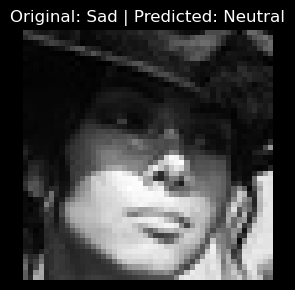

In [32]:
import random

# Randomly select an image index from validation set
n = random.randint(0, len(true_classes) - 1)

# Get the image from validation set
# Find which batch contains image n
batch_idx = n // batch_size
img_idx = n % batch_size

# Get that specific batch
validation_set.reset()
for i in range(batch_idx + 1):
    batch_images, batch_labels = validation_set[i]

# Extract the specific image
image = batch_images[img_idx]
orig_labl = class_labels[true_classes[n]]
pred_labl = class_labels[predicted_classes[n]]

# Display
plt.figure(figsize=(3, 3))
plt.imshow(image[:,:,0], cmap='gray')
plt.title(f"Original: {orig_labl} | Predicted: {pred_labl}")
plt.axis('off')
plt.tight_layout()
plt.show()